In [1]:
%pip install paho-mqtt scikit-fuzzy python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
from dotenv import load_dotenv
import numpy as np
import skfuzzy as fuzz
import time
import paho.mqtt.client as paho
from paho import mqtt
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Especificar o caminho do arquivo .env
dotenv_path = 'Variables.env'
if not os.path.exists(dotenv_path):
    raise FileNotFoundError(f"Arquivo {dotenv_path} não encontrado.")

load_dotenv(dotenv_path)

# Obtém as variáveis de ambiente - Segurança adicional para evitar o vazamento das credenciais em texto claro
mqtt_username = os.getenv('MQTT_USERNAME')
mqtt_password = os.getenv('MQTT_PASSWORD')
mqtt_url = os.getenv('MQTT_URL')
mqtt_port = os.getenv('MQTT_PORT')

# Verificar se todas as variáveis de ambiente foram carregadas corretamente
if not all([mqtt_username, mqtt_password, mqtt_url, mqtt_port]):
    raise ValueError("Uma ou mais variáveis de ambiente não foram carregadas corretamente.")

mqtt_port = int(mqtt_port)  # Converter para inteiro

# Definindo callbacks para diferentes eventos para ver se funciona, imprimir a mensagem etc.
def on_connect(client, userdata, flags, rc, properties=None):
    if rc == 0:
        print("Conexão estabelecida com sucesso!")
    else:
        print("CONNACK received with code %s." % rc)

# Com este callback você pode ver se sua publicação foi bem-sucedida
def on_publish(client, userdata, mid, properties=None):
    print("mid: " + str(mid))

# Imprimir qual tópico foi inscrito
def on_subscribe(client, userdata, mid, granted_qos, properties=None):
    print("Subscribed: " + str(mid) + " " + str(granted_qos))

# Imprimir mensagem, útil para verificar se foi bem-sucedido
def on_message(client, userdata, msg):
    print(msg.topic + " " + str(msg.qos) + " " + str(msg.payload))

client = paho.Client(paho.CallbackAPIVersion.VERSION2, client_id="", userdata=None, protocol=paho.MQTTv5)
client.on_connect = on_connect  

# Habilita o TLS para uma conexão segura (diferencial) 
client.tls_set(tls_version=mqtt.client.ssl.PROTOCOL_TLS)

# Configurar nome de usuário e senha
client.username_pw_set(mqtt_username, mqtt_password)
# Conectar ao HiveMQ Cloud na porta especificada
client.connect(mqtt_url, mqtt_port)

# Configurar callbacks
client.on_subscribe = on_subscribe
client.on_message = on_message
client.on_publish = on_publish


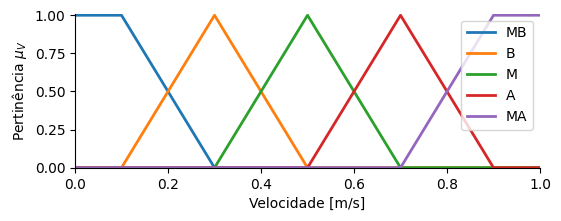

In [25]:
velocidade = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'velocidade')

velocidade['MB'] = fuzz.trapmf(velocidade.universe, [0, 0, 0.1, 0.3])
velocidade['B'] = fuzz.trimf(velocidade.universe, [0.1, 0.3, 0.5])
velocidade['M'] = fuzz.trimf(velocidade.universe, [0.3, 0.5, 0.7])
velocidade['A'] = fuzz.trimf(velocidade.universe, [0.5, 0.7, 0.9])
velocidade['MA'] = fuzz.trapmf(velocidade.universe, [0.7, 0.9, 1, 1])

velocidade.view()

[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

fig = plt.gcf(); axes = fig.gca(); fig.set_size_inches(6, 2)
axes.set_xlabel(xlabel='Velocidade [m/s]'); axes.set_ylabel(ylabel='Pertinência $\mu_{V}$');
plt.legend(loc='upper right');